In [1]:
import os
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import cv2
from PIL import Image
import secrets
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from datetime import datetime
from tqdm import tqdm
import torchvision.models as models
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import matplotlib.pyplot as plt

C:\Users\kimaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define paths for dataset and model
base_path = "C:/Users/kimaa/OneDrive/Desktop"

data_path = os.path.join(base_path, "imgs", "train")
model_dir = os.path.join(base_path, "model", "hybrid_network")

os.makedirs(model_dir, exist_ok=True)

print("Data Directory:", data_path)
print("Model Directory:", model_dir)

Data Directory: C:/Users/kimaa/OneDrive/Desktop\imgs\train
Model Directory: C:/Users/kimaa/OneDrive/Desktop\model\hybrid_network


In [3]:
if os.path.exists(data_path):
    print("Directory exists. Contents:", os.listdir(data_path))
else:
    print("Directory does not exist. Check the path.")

Directory exists. Contents: ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [4]:
# Preprocessing functions for the images
def enhance_brightness(img, value_increment):
    hsv_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_img)
    v = cv2.add(v, value_increment)
    final_hsv = cv2.merge((h, s, v))
    return Image.fromarray(cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB))

def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    return img.point(lambda c: 128 + factor * (c - 128))

class RandomContrastBrightnessTransform:
    def __call__(self, img):
        if secrets.randbelow(2) == 0:
            img = enhance_brightness(img, secrets.randbelow(26))
            img = change_contrast(img, secrets.randbelow(51))
        else:
            img = change_contrast(img, secrets.randbelow(51))
            img = enhance_brightness(img, secrets.randbelow(26))
        return img


In [5]:
# Image transformations
transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.02, 0.02), shear=0.01, scale=(0.95, 1.05)),
    RandomContrastBrightnessTransform(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [6]:
# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

In [7]:
# Split the dataset 
total_size = len(full_dataset)
train_size = int(0.8 * total_size)  
test_size = total_size - train_size  

In [8]:
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [9]:

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [10]:

images, labels = next(iter(train_loader))

print("Shape of images in a batch:", images.shape)

Shape of images in a batch: torch.Size([128, 3, 224, 224])


In [11]:
class EarlyStopping:
  
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if val_loss < self.val_loss_min:
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), self.path)
            self.val_loss_min = val_loss
def save_final_model(model, path='final_model.pt'):

    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

In [12]:
class HybridCNNTransformer(nn.Module):
    def __init__(self, num_classes=10, feature_dim=512, num_heads=8, num_layers=3):
        super(HybridCNNTransformer, self).__init__()
    
        self.cnn = models.resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  

        self.dim_reduction = nn.Linear(2048, feature_dim)

        self.encoder_layer = TransformerEncoderLayer(d_model=feature_dim, nhead=num_heads)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):

        cnn_features = self.cnn(x)  # Output shape: [batch_size, 2048, 1, 1]
        cnn_features = cnn_features.squeeze()  

        cnn_features = self.dim_reduction(cnn_features)  

        cnn_features = cnn_features.unsqueeze(1)  

        transformer_output = self.transformer_encoder(cnn_features)  

        transformer_output = transformer_output.mean(dim=1)

        logits = self.fc(transformer_output)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridCNNTransformer()

C:\Users\kimaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kimaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\kimaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\modules\transformer.py:286: UserWarni

In [13]:
print(model)

HybridCNNTransformer(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Co

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, device='cuda'):
    early_stopping = EarlyStopping(patience=5, verbose=True, path='best_model.pth')
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Train loop with tqdm
        train_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]', leave=False)
        for inputs, labels in train_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            # Update tqdm postfix to show loss and accuracy on training batch
            train_tqdm.set_postfix(loss=loss.item(), accuracy=correct_train / total_train)

        train_losses.append(total_train_loss / total_train)
        train_accuracies.append(correct_train / total_train)

        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        # Validation loop with tqdm
        val_tqdm = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]', leave=False)
        with torch.no_grad():
            for inputs, labels in val_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

                # Update tqdm postfix to show loss and accuracy on validation batch
                val_tqdm.set_postfix(loss=loss.item(), accuracy=correct_val / total_val)

        val_losses.append(total_val_loss / total_val)
        val_accuracies.append(correct_val / total_val)

        print(f'Epoch {epoch+1}/{epochs} Train loss: {train_losses[-1]:.4f} Acc: {train_accuracies[-1]:.4f} Val loss: {val_losses[-1]:.4f} Acc: {val_accuracies[-1]:.4f}')

        early_stopping(val_losses[-1], model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

In [16]:
start_time = datetime.now()
train_losses, train_accuracies, test_losses, test_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=20, device=device)

Epoch 1/5 Train loss: 0.3667 Acc: 0.8815 Val loss: 0.0582 Acc: 0.9864
Validation loss decreased (inf --> 0.058238).  Saving model ...


Epoch 2/5 Train loss: 0.0489 Acc: 0.9873 Val loss: 0.0661 Acc: 0.9799
EarlyStopping counter: 1 out of 5


Epoch 3/5 Train loss: 0.0323 Acc: 0.9910 Val loss: 0.0566 Acc: 0.9866
Validation loss decreased (0.058238 --> 0.056556).  Saving model ...


Epoch 4/5 Train loss: 0.0280 Acc: 0.9919 Val loss: 0.0358 Acc: 0.9918
Validation loss decreased (0.056556 --> 0.035809).  Saving model ...


Epoch 5/5 Train loss: 0.0308 Acc: 0.9916 Val loss: 0.0344 Acc: 0.9922
Validation loss decreased (0.035809 --> 0.034447).  Saving model ...


In [17]:
end_time = datetime.now()
print('Training completed in:', end_time - start_time)

Training completed in: 3:36:07.817758


In [18]:
def plot_metrics(train_losses,train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Training Accuracy')
    plt.plot(epochs, val_losses, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

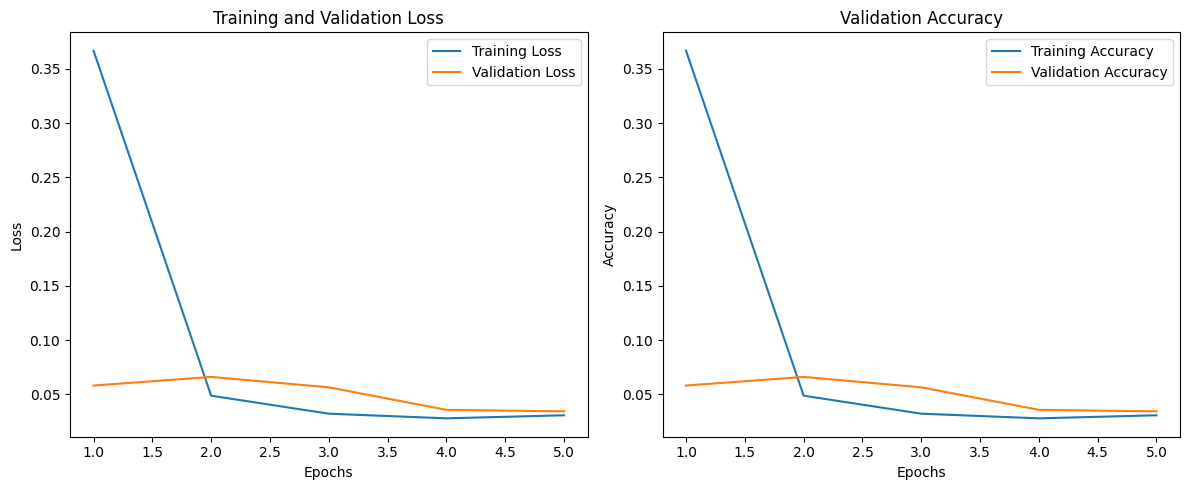

In [19]:
plot_metrics(train_losses,train_accuracies, test_losses, test_accuracies)